In [23]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
from utility.ffqd_mnist import FFQD_Dataset, label_for_id
from torch.utils.data import DataLoader
import torchvision.transforms as T

def image_and_pad (x):
    return nn.functional.pad(torch.Tensor(x).view(1,28,28),(2,2,2,2))

training_data = FFQD_Dataset('ffqd_mnist/', train=True, transform=image_and_pad)
train_dataloader = DataLoader(training_data, batch_size=64)

test_data = FFQD_Dataset('ffqd_mnist/', transform=image_and_pad)
test_dataloader = DataLoader(test_data, batch_size=64)
device = 'cpu'

In [24]:
training_data[1][0].shape

torch.Size([1, 32, 32])

In [18]:
# by: https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/
class LeNet(torch.nn.Module):
    def __init__(self, output_size=10):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        # see: https://madebyollin.github.io/convnet-calculator/

        self.fc1 = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(84, output_size)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.fc3(out)
        return out
        # return y

In [19]:
model = LeNet()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)
criterion = torch.nn.CrossEntropyLoss()

def reset_model():
    global model, optimizer
    model = LeNet()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)


In [26]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch_id, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # print(X.shape)
        # calculate loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)


        # print( y_pred.dtype, y_pred.shape)
        # print(loss)

        # backprop loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(f"({batch_id}) loss: {loss:>7}")


In [15]:
def test_one_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred_y = model(X)
            test_loss += loss_fn(pred_y, y).item()
            correct += (pred_y.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct


In [77]:
reset_model()
# old_weights = torch.Tensor(np.array(model.get_parameter("fc.weight").detach().numpy())) # copy old weights
# old_weights = model.get_parameter("mlp_stack.0.weight").clone().detach()
for i in range(10):
    train_one_epoch(train_dataloader, model, criterion, optimizer)
    print(test_one_epoch(test_dataloader, model, criterion))

(0) loss: 2.306349605321884
(100) loss: 2.307061839848757
(200) loss: 2.2914072573184967
(300) loss: 2.289260011166334
(400) loss: 2.2974664717912674
(500) loss: 2.2862329818308353
(600) loss: 2.2898735851049423
(700) loss: 2.261129751801491
(800) loss: 2.235496185719967
(2.1858237989874945, 0.3780181818181818)
(0) loss: 2.199608188122511
(100) loss: 1.875803366303444
(200) loss: 1.2941409200429916
(300) loss: 1.097106131608598
(400) loss: 1.052986490423791
(500) loss: 0.9744806111266371
(600) loss: 1.0448555076727644
(700) loss: 0.7014282086747698
(800) loss: 0.7946929682511836
(0.9547667382943039, 0.6829454545454545)
(0) loss: 1.050978501138161
(100) loss: 0.7080874305029283
(200) loss: 0.7658197674027178
(300) loss: 0.5943280484789284
(400) loss: 0.8123458261106862
(500) loss: 0.7484523208440805
(600) loss: 0.7270231695874827
(700) loss: 0.49454694143059896
(800) loss: 0.6511821897729533
(0.8162083060507185, 0.7350909090909091)
(0) loss: 0.9708337488700636
(100) loss: 0.502232603983

In [41]:
for name, par in model.named_parameters():
    print(name, par.shape)

layer1.0.weight torch.Size([6, 1, 5, 5])
layer1.0.bias torch.Size([6])
layer2.0.weight torch.Size([16, 6, 5, 5])
layer2.0.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])


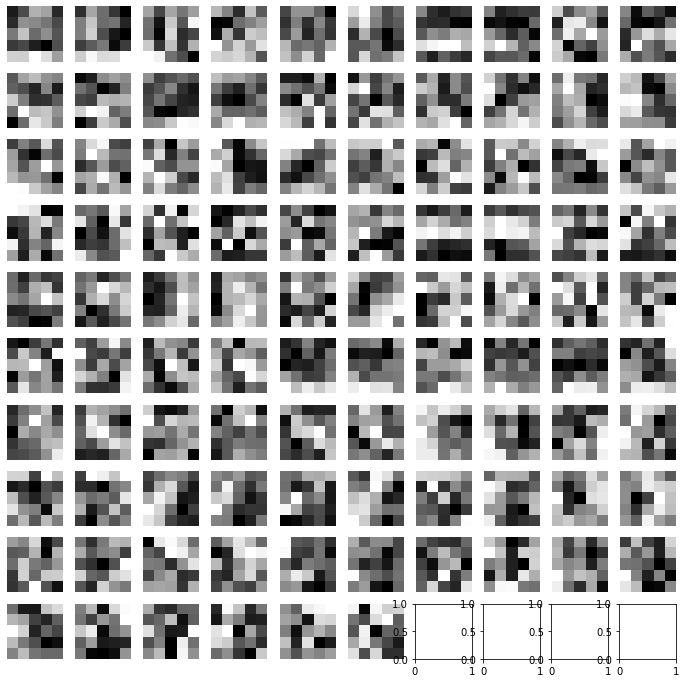

In [79]:
l0_weights = model.get_parameter('layer2.0.weight').detach()
# l0_weights_diff = l0_weights- old_weights
f, axs = plt.subplots(10,10,figsize=(12,12))
axs = axs.flatten()
for i in range(16):
    for ii in range(6):
        axs[i*6+ii].imshow(l0_weights[i,ii], cmap="gray")
        axs[i*6+ii].axis('off')

torch.Size([1, 1, 32, 32])


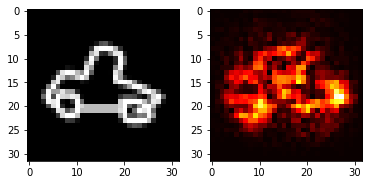

In [80]:
test_batch, test_batch_label = next(iter(test_dataloader))

image = test_batch[23].unsqueeze(0)
label = test_batch_label[23].unsqueeze(0)

fig, axs = plt.subplots(1,2, figsize=(6,6))
axs= axs.flatten()

axs[0].imshow(image.view(32,32), cmap='gray')
model.eval()
x_in = image.clone().requires_grad_()
print(x_in.shape)
model.zero_grad()
pred = model(x_in)
# loss = criterion(pred, label)
# loss.backward()

pred_index = pred.argmax()

pred_max = pred[0, pred_index]
# print(pred_max)
pred_max.backward()

# # # saliency = nn.ReLU()(x_in.grad)
saliency = x_in.grad.detach().abs()[0]
# # # print(saliency.shape, saliency)
saliency = saliency.reshape(32, 32)
# #
axs[1].imshow(saliency, cmap="hot")


plt.show()

ground truth: 3 / car
predcition: 3 / car
attacked prediction: 8 / mustache


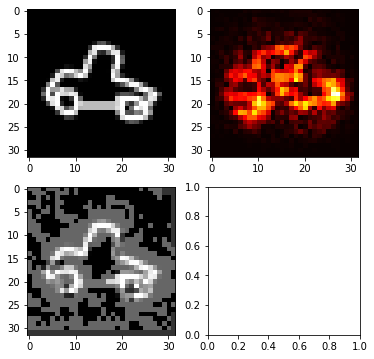

In [90]:
test_batch, test_batch_label = next(iter(test_dataloader))

item_id = 23 # 23, 55(rob), 34(rob)

image = test_batch[item_id].unsqueeze(0)
print(f"ground truth: {np.argmax(test_batch_label[item_id])} / {label_for_id(np.argmax(test_batch_label[item_id]))}")

fig, axs = plt.subplots(2,2, figsize=(6,6))
axs= axs.flatten()

axs[0].imshow(image.view(32,32), cmap='gray')

x_in = image.clone().requires_grad_()
model.zero_grad()
pred = model(x_in)
pred_index = pred.argmax()
print(f"predcition: {pred_index.item()} / {label_for_id(pred_index.item())}")
pred_max = pred[0, pred_index]
# print(pred_max)
pred_max.backward()


saliency = x_in.grad.detach().abs()[0]
# print(saliency.shape, saliency)
saliency = saliency.reshape(32, 32)
axs[1].imshow(saliency, cmap="hot")

model.zero_grad()
pred = model(x_in)
pred_attack = pred[0, 5]
pred_attack.backward()
# print(x_in.grad)
x_attack = 0.3 *image + 0.1*(x_in.grad.detach()[0].sign()) #nn.ReLU()

axs[2].imshow(x_attack.view(32,32), cmap='gray')
pred = model(x_attack)
pred_index = pred.argmax()
print(f'attacked prediction: {pred_index.item()} / {label_for_id(pred_index.item())}')

plt.show()
